# Test

In [1]:
import tensorflow as tf

from tensorflow import keras

In [2]:
#TEMP LIBRARIES

#library to read and import file from drive
import os
import zipfile

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#images
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn_image as isns
import skimage.exposure

import numpy as np
from numpy.random import default_rng
import random
import imutils

#### Functions

In [3]:
def load_model(path="./"):
    return keras.models.load_model(path)

## Load pretrained model

In [4]:
autoencoder = load_model("../Models/autoencoderFC")

## Test image differences

In [5]:
def detect_anom(true_img, rec_img):
    anomaly=False
    
    # All values between 0 and 1
    rec_img[np.where((rec_img > [1]))] = 1
    rec_img[np.where((rec_img < [0]))] = 0

    # Calculate the difference between the original image and the reconstructed one
    diff = cv.absdiff(true_img, rec_img)

    # Scale values from 0..1 to 0..255 (required for opencv functions)
    diff = (diff*255).astype('uint8')

    # Threshold to make the image only white and black (so higlight the anomalies in white)
    ret, th = cv.threshold(diff, 160, 255, cv.THRESH_BINARY)

    # Find the countours of the anomalies
    cnts, _ = cv.findContours(th, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

    # For every anomaly, draw the bounding box
    anomalies_img = true_img.copy()
    for c in cnts:
        (x, y, w, h) = cv.boundingRect(c)
        anomalies_img = cv.rectangle(anomalies_img, (x-20, y-20), (x + w + 20, y + h + 20), (0, 255, 0), 2)
        # If some anomaly is found, we classify the image as anomalous
        anomaly=True
    
    return anomaly, anomalies_img.astype('float32')/255.

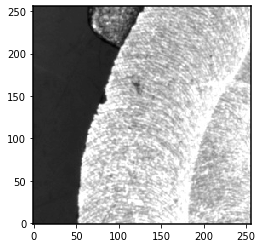

In [318]:
test_img = cv.imread('../Data/Prepared/Test/NOK/NOK_0-8.jpg', cv.IMREAD_GRAYSCALE).astype('float32')/255.
plt.imshow(test_img, cmap='gray')

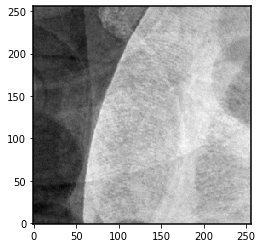

In [319]:
test_rec = autoencoder.predict(np.expand_dims(np.expand_dims(test_img, 0), -1))
test_rec = np.squeeze(test_rec[0], -1)
plt.imshow(test_rec, cmap='gray')

In [320]:
anomal, anomal_img = detect_anom(test_img, test_rec)
anomal

True

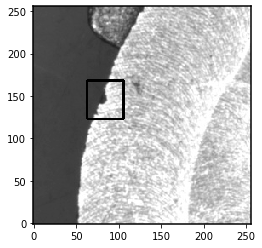

In [321]:
plt.imshow(anomal_img, cmap='gray')

## Functions from preparation

In [6]:
# Function to divide images into smaller parts
def split_patches(img, n_patches=16):
    imgs_list = []
    dim = int(img.shape[0]//(16**(1/2)))
    for i in range(0, n_patches):
        x = int(dim*(i%(16**(1/2))))
        y = int(dim*(i//(16**(1/2))))
        imgs_list.append(img[y:y+dim, x:x+dim])
    return imgs_list

In [7]:
# Function to scale pixel values from 0..255 to 0..1
def scale_pixels(img, scale_range=(0, 1)):
    return img.astype('float32') / 255.

In [8]:
# Function to resize images
def resize(img, size=(1024, 1024)):
    return cv.resize(img, size)

In [9]:
# Function to crop image 
def crop(img, mask=False):
    #gaussian filter
    tmp = cv.GaussianBlur(img,(21,21),0)

    ret1, th1 = cv.threshold(tmp, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    ret2, th2 = cv.threshold(img, 120, 255, cv.THRESH_BINARY)

    x, y, w, h = cv.boundingRect(th1)

    if(w<h):
        diff = h-w
        y = y+(diff//2)
        h = h-diff
    #return input image with crop and in b&w
    border = 50
    if(mask):
        return th2[y-border:y+h+border, x-border:x+w+border]
    return img[y-border:y+h+border, x-border:x+w+border]

## Model evaluation

In [92]:
img = cv.imread('../Data/Prepared/Test/NOK/NOK_3.jpg', cv.IMREAD_GRAYSCALE)

In [93]:
def predict_image(img, model):
    img = crop(img)
    img = resize(img)
    img = scale_pixels(img)
    slices = split_patches(img)
    anomaly = False
    slices_anomal_bound = []
    for slice in slices:
        slice_rec = model.predict(np.expand_dims(np.expand_dims(slice, 0), -1))
        slice_rec = np.squeeze(slice_rec[0], -1)
        anomal, anomal_img = detect_anom(slice, slice_rec)
        if anomal:
            anomaly=True
        slices_anomal_bound.append(anomal_img)

    horizion_concat = []
    for i in range(0, 16, 4):
        horizion_concat.append(cv.hconcat([slices_anomal_bound[i], slices_anomal_bound[i+1], slices_anomal_bound[i+2], slices_anomal_bound[i+3]]))
    img_total = cv.vconcat([horizion_concat[0], horizion_concat[1], horizion_concat[2], horizion_concat[3]])

    return anomaly, img_total


In [94]:
anom, img_anom = predict_image(img, autoencoder)

In [95]:
anom

True

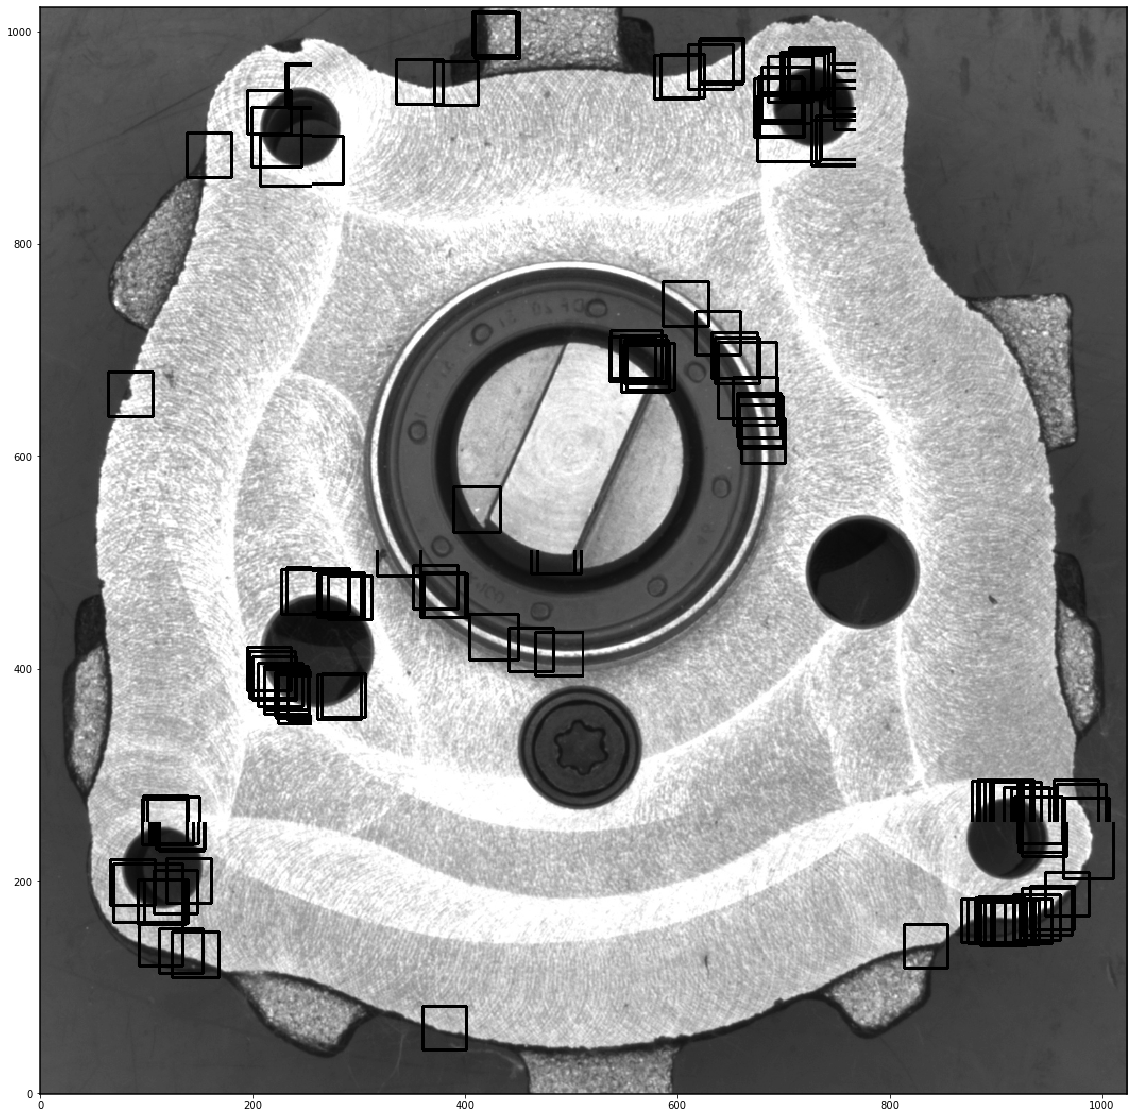

In [96]:
plt.figure(figsize=(20, 20))
plt.imshow(img_anom, cmap='gray')